# Data chunking

## Authors & Contributors
### Authors
- Tina Odaka, Ifremer (France), [@tinaok](https://github.com/tinaok)
- Pier Lorenzo Marasco, Ispra (Italy), [@pl-marasco](https://github.com/pl-marasco)

### Contributors
- Anne Fouilloux, Simula Research Laboratory (Norway), [@annefou](https://github.com/annefou)
- Guillaume Eynard-Bontemps, CNES (France), [@guillaumeeb](https://github.com/guillaumeeb)



<div class="alert alert-info">
<i class="fa-question-circle fa" style="font-size: 22px;color:#666;"></i> Overview
    <br>
    <br>
    <b>Questions</b>
    <ul>
        <li>Why do chunking matter?</li>
        <li>How can I read datasets by chunks to optimize memory usage?</li>
    </ul>
    <b>Objectives</b>
    <ul>
        <li>Learn about chunking</li>
        <li>Learn about zarr </li>
        <li>Use kerchunk to consolidate chunk metadata and prepare single ensemble datasets for parallel computing</li>
    </ul>
</div>

## Context

When dealing with large data files or collections, it's often impossible to load all the data you want to analyze into a single computer's RAM at once. This is a situation where the Pangeo ecosystem can help you a lot. Xarray offers the possibility to work lazily on data __chunks__, which means pieces of an entire dataset. By reading a dataset in __chunks__ we can process our data piece by piece on a single computer and even on a distributed computing cluster using Dask (Cloud or HPC for instance).

How we will process these 'chunks' in a parallel environment will be discussed in [dask_introduction](./dask_introduction.ipynb). The concept of __chunk__ will be explained here.

When we process our data piece by piece, it's easier to have our input or ouput data also saved in __chunks__. [Zarr](https://zarr.readthedocs.io/en/stable/) is the reference library in the Pangeo ecosystem to save our Xarray multidimentional datasets in __chunks__.

[Zarr](https://zarr.readthedocs.io/en/stable/) is not the only file format which uses __chunk__. We will also be using [kerchunk library](https://fsspec.github.io/kerchunk/) in this notebook to build a virtual __chunked__ dataset based on NetCDF files, and show how it optimizes the access and analysis of large datasets.

The analysis is very similar to what we have done in previous episodes, however we will use data on a global coverage and not only on a small geographical area (e.g. Lombardia).

### Data

In this episode, we will be using Global Long Term Statistics (1999-2019) products provided by the [Copernicus Global Land Service](https://land.copernicus.eu/global/index.html) and access them through [S3-comptabile storage](https://en.wikipedia.org/wiki/Amazon_S3) ([OpenStack Object Storage "Swift"](https://wiki.openstack.org/wiki/Swift)) with a data catalog we have created and made publicly available.

## Setup

This episode uses the following main Python packages:

- fsspec {cite:ps}`d-fsspec-2018`
- s3fs {cite:ps}`d-s3fs-2016`
- xarray {cite:ps}`d-xarray-hoyer2017` with [`netCDF4`](https://pypi.org/project/h5netcdf/) and [`h5netcdf`](https://pypi.org/project/h5netcdf/) engines
- dask {cite:ps}`d-dask-2016`
- kerchunk {cite:ps}`d-kerchunk-2021`
- geopandas {cite:ps}`d-geopandas-jordahl2020`
- matplotlib {cite:ps}`d-matplotlib-Hunter2007`

Please install these packages if not already available in your Python environment (see [Setup page](https://pangeo-data.github.io/foss4g-2022/before/setup.html)).

### Packages

In this episode, Python packages are imported when we start to use them. However, for best software practices, we recommend you to install and import all the necessary libraries at the top of your Jupyter notebook.

## Global LTS

In the previous episode, we used Long Term statistics time-series for the region of Lombardy e.g. a very small area. Now we would like to use the original dataset that has a global coverage. Let us first open a single file (for January 1999-2019) to understand how much larger the global dataset is.

In [1]:
import fsspec
import s3fs
import xarray as xr

In [2]:
fs = s3fs.S3FileSystem(anon=True,
      client_kwargs={
         'endpoint_url': 'https://object-store.cloud.muni.cz'
      })

In [3]:
s3path = 's3://foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-1221_GLOBE_VGT-PROBAV_V3.0.1.nc'

As shown in the [Data discovery](./data_discovery.ipynb) chapter, when we have several files to read at once, we need to use Xarray `open_mfdataset` instead of `open_dataset`. It takes a list in input, and not a single element. We can also use `open_mfdataset` with one file as done below, just as an introduction.

In [4]:
%%time
LTS = xr.open_mfdataset([fs.open(s3path)])
LTS

CPU times: user 585 ms, sys: 81 ms, total: 666 ms
Wall time: 720 ms


<xarray.Dataset>
Dimensions:  (lon: 40320, lat: 15680)
Coordinates:
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat      (lat) float64 80.0 79.99 79.98 79.97 ... -59.97 -59.98 -59.99
Data variables:
    crs      |S1 ...
    min      (lat, lon) float32 dask.array<chunksize=(15680, 40320), meta=np.ndarray>
    median   (lat, lon) float32 dask.array<chunksize=(15680, 40320), meta=np.ndarray>
    max      (lat, lon) float32 dask.array<chunksize=(15680, 40320), meta=np.ndarray>
    mean     (lat, lon) float32 dask.array<chunksize=(15680, 40320), meta=np.ndarray>
    stdev    (lat, lon) float32 dask.array<chunksize=(15680, 40320), meta=np.ndarray>
    nobs     (lat, lon) float32 dask.array<chunksize=(15680, 40320), meta=np.ndarray>
Attributes: (12/19)
    Conventions:          CF-1.6
    parent_identifier:    urn:cgls:global:ndvi_stats_all
    identifier:           urn:cgls:global:ndvi_stats_all:NDVI-LTS_1999-2019-1...
    long_name:            Normalized Difference Vegetation Index
    title:                Normalized Difference Vegetation Index: Long Term S...
    product_version:      V3.0.1
    ...                   ...
    source:               Derived from EO satellite imagery
    processing_mode:      Offline
    references:           https://land.copernicus.eu/global/products/ndvi
    copyright:            Copernicus Service information 2021
    archive_facility:     VITO
    history:              2021-03-01 - Processing line NDVI LTS

Using `open_mfdataset` automatically switch from Numpy Arrays to Dask Arrays as the data structure used by Xarray. 

<div class="alert alert-warning">
    <i class="fa-check-circle fa" style="font-size: 22px;color:#666;"></i> <b>Go Further</b>
    <br>
    <ul>
        <li>You can try to open the same file with xr.open_dataset(fs.open(s3path))</li> 
        <li>Compare the xarray output between open_mfdataset and open_dataset, what do you see as difference?</li>
            </ul>
</div>

## What is a __chunk__

If you look carefully to `LTS`, each Data Variable is a `dask.array` with a chunk size of `(15680, 40320)`. So basically accessing one data variable would load arrays of dimensions `(15680, 40320)` into the computer's RAM. You can see this information and more details by clicking the icon as indicated in the image below.

![Dask.array](../figures/datasize.png)

When you open one or several netCDF files with `open_mdfataset`, by default, the chunks correspond to the entire size of the variable data array read from each file. When you need to analyze large files, a computer's memory may not be sufficient anymore (see in this example, 2.36GiB for one chunk!).

This is where understanding and using chunking correctly comes into play.


__Chunking__ is splitting a dataset into small pieces. 

Original dataset is in one piece,  
![Dask.array](../figures/notchunked.png)

and we split it into several smaller pieces.  
![Dask.array](../figures/chunked.png)

We split it into pieces so that we can process our data block by block or __chunk__ by __chunk__.

In our case, for the moment, the dataset is composed of several files, so already several pieces (or just one in the example above), and Xarray just creates one chunk for each file.

## Using chunks within a single file

When we want to read one or several big files, or files with Big Arrays (the above 2.36GiB per array is already quite big), we will almost certainly need chunks so that we can process files piece by piece.

This is usually done with Xarray using the `chunks` kwarg when opening a file with `xr.open_dataset` or with `xr.open_mfdataset`.

In [5]:
LTS = xr.open_dataset(fs.open(s3path), chunks={"lon": 40320 / 2, "lat": 15680 / 2})
LTS

<xarray.Dataset>
Dimensions:  (lon: 40320, lat: 15680)
Coordinates:
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
  * lat      (lat) float64 80.0 79.99 79.98 79.97 ... -59.97 -59.98 -59.99
Data variables:
    crs      |S1 ...
    min      (lat, lon) float32 dask.array<chunksize=(7840, 20160), meta=np.ndarray>
    median   (lat, lon) float32 dask.array<chunksize=(7840, 20160), meta=np.ndarray>
    max      (lat, lon) float32 dask.array<chunksize=(7840, 20160), meta=np.ndarray>
    mean     (lat, lon) float32 dask.array<chunksize=(7840, 20160), meta=np.ndarray>
    stdev    (lat, lon) float32 dask.array<chunksize=(7840, 20160), meta=np.ndarray>
    nobs     (lat, lon) float32 dask.array<chunksize=(7840, 20160), meta=np.ndarray>
Attributes: (12/19)
    Conventions:          CF-1.6
    parent_identifier:    urn:cgls:global:ndvi_stats_all
    identifier:           urn:cgls:global:ndvi_stats_all:NDVI-LTS_1999-2019-1...
    long_name:            Normalized Difference Vegetation Index
    title:                Normalized Difference Vegetation Index: Long Term S...
    product_version:      V3.0.1
    ...                   ...
    source:               Derived from EO satellite imagery
    processing_mode:      Offline
    references:           https://land.copernicus.eu/global/products/ndvi
    copyright:            Copernicus Service information 2021
    archive_facility:     VITO
    history:              2021-03-01 - Processing line NDVI LTS

If you look into details of any variable in the representation above, you'll see that each array is chunked into 4 pieces, 602.96 MiB each, which is already more manageable.

<div class="alert alert-warning">
    <i class="fa-check-circle fa" style="font-size: 22px;color:#666;"></i> <b>Warning</b>
    <br>
    <br>
    To access chunk with 602.96MiB each, your proces will first acces to 2GiB of data as the file is not originaly chunked.
</div>

Xarray `Dataset` and `DataArray` objects also have a `chunk` function. We can use it to change our dataset chunks size.
Lets try to 'chunk' our data array LTS.nobs using this command.

Let's first re-open the same dataset without any chunking.

In [6]:
LTS = xr.open_dataset(fs.open(s3path))

As we would like to play with small sized array, we first select a subset of data as you've learned in [xarray_introduction](./xarray_introduction.ipynb). 

In [7]:
test = LTS.nobs.sel(lat=slice(80.,70.), lon=slice(70.,90))
test

<xarray.DataArray 'nobs' (lat: 1121, lon: 2240)>
[2511040 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 70.0 70.01 70.02 70.03 ... 89.96 89.97 89.98 89.99
  * lat      (lat) float64 80.0 79.99 79.98 79.97 ... 70.03 70.02 70.01 70.0
Attributes:
    standard_name:  normalized_difference_vegetation_index number_of_observat...
    grid_mapping:   crs
    units:          
    valid_range:    [  1 250]
    cell_methods:   area: mean

The test value has dimensions `(1121, 2240)`.  We will chunk it on 600x600 pieces using the following command. 

In [8]:
test=test.chunk(600)
test

<xarray.DataArray 'nobs' (lat: 1121, lon: 2240)>
dask.array<xarray-<this-array>, shape=(1121, 2240), dtype=float32, chunksize=(600, 600), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float64 70.0 70.01 70.02 70.03 ... 89.96 89.97 89.98 89.99
  * lat      (lat) float64 80.0 79.99 79.98 79.97 ... 70.03 70.02 70.01 70.0
Attributes:
    standard_name:  normalized_difference_vegetation_index number_of_observat...
    grid_mapping:   crs
    units:          
    valid_range:    [  1 250]
    cell_methods:   area: mean

As you can see in the above graphics we got 8 __chunks__.  These 8 chunks are noted as (0,0) ..(0,3) (1,0),..(1,3) as you can see in the next visualisation.

## Operations on a chunked dataset

Let's have a look of our chunked test dataset backend representation.

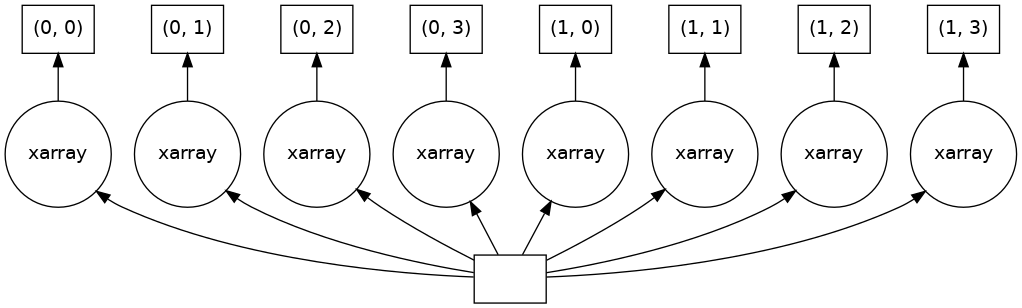

In [9]:
test.data.visualize()

` test.data` is the backend array Python representation of Xarray's Data Array, [__Dask Array__](https://docs.dask.org/en/stable/array.html) when using chunking, Numpy by default.

We will introduce Dask arrays and Dask graphs visualization in the next section [dask_introduction](./dask_introduction.ipynb).

Anyway, when applying `chunk` function you may have the impression that the chunks sizes just changes and everything will be fine.

However, as you can see in the graph visualization above, Xarray will actually have to fetch at least one entire initial chunk that was defined when opening the Dataset at first before rechunking at a smaller size or even selecting one value. This is true when applying any funtions on any values: Xarray will work by loading entire chunks.

You can imagine that it will not be very optimal if you load one file as an entire chunk, or if your initial chunks are too big (your Python Jupyter kernel may crash!), especially with large numbers of files and large files.

You can find a really nice article by Dask team on how to chose the right chunk size [here](https://blog.dask.org/2021/11/02/choosing-dask-chunk-sizes).

<div class="alert alert-warning">
    <i class="fa-check-circle fa" style="font-size: 22px;color:#666;"></i> <b>Go Further</b>
    <br>
    <br>
    You can try to apply different ways for specifying chunk.
    <ul>
        <li> chunks = 'auto' -> Xarray relies on Dask to use an ideal size according to the preferred chunk sizes</li>
        <li> chunks = -1 -> the entire array will be used as a single chunk
        <li> chunks = "1MiB" -> Xarray seeks the size according to a specific memory target expressed in MiB</li>
        <li> chunks = {'lat'=-1, 'lon'= 1000} -> chunks of entire _lat_ dimension, but splitted every 1000 values on _lon_ dimension</li>
        <li> compare the resulting chunked data's shape, size, tasks, data.visualize..... What do you see?</li>
    </ul>
</div>

## So, why chunks?

In the end, chunks are mandatory for accessing files or dataset that are bigger than a singles computer's memory. If all the data has to be accessed, it can be done sequentially e.g. chunks are processed one after the othe).

Moreover, chunks allow for distributed processing and so increased speed for your data analysis, as seen in the next episode.

### Chunks and files

Xarray chunking possibilities also relies on the underlying input or output file format used. Most modern file format allows to store a dataset or a single file using chunks. NetCDF4 uses chunks when storing a file on the disk through the use of HDF5. Any read of data in a NetCDF4 file will lead to the load of at least one chunk of this file. So when reading one of its chunk as defined in `open_dataset` call, Xarray will take advantage of native file chunking and won't have to read the entire file too.

Yet, it is really important to note that __Xarray chunks and file chunks are not necessarily the same__. It is however a really good idea to configure Xarray chunks so that they align well on input file format chunks (so ideally, Xarray chunks should contain one or several input file chunks).

## Zarr storage format

This brings to our next subjects [Zarr](https://zarr.readthedocs.io/en/stable/) and [Kerchunk](https://fsspec.github.io/kerchunk/).

If we can have our original dataset already 'chunked' and accessed in an optimized way according to it's actual byte storage on disk, we won't need to load entire dataset every time, and our data anlayzis, even working on the entire dataset, will be greatly optimized.

Let's convert our input data into Zarr format so that we can learn what it is.

In [10]:
test.to_dataset().to_zarr('test.zarr',mode='w')

<div class="alert alert-info">
<i class="fa-check-circle fa" style="font-size: 22px;color:#666;"></i> <b>Warning</b>
<br>
<ul>
<li>DataArray can not be saved as 'zarr'. Before saving your data to zarr, you will need to convert it into a DataSet</li>
</ul>
</div>

<div class="alert alert-warning">
    <i class="fa-check-circle fa" style="font-size: 22px;color:#666;"></i> <b>Exercise</b>
    <br>
    <ul>
        <li>You can try to explore the zarr file you just created using `ls -la test.zarr` and  `ls -la test.zarr/nobs `</li>
        <li>You can explore zarr metadata file by `cat test.zarr/.zmetadata` </li>
        <li>Did you find the __chunks__ we defined previously in your zarr file? </li>
    </ul>
</div>

In [11]:
!du -sh test.zarr/

92K	test.zarr/


In [12]:
!ls -al test.zarr/nobs

total 48
drwxr-xr-x 2 jovyan jovyan 4096 Oct 11 21:49 .
drwxr-xr-x 5 jovyan jovyan 4096 Oct 11 21:49 ..
-rw-r--r-- 1 jovyan jovyan  341 Oct 11 21:49 .zarray
-rw-r--r-- 1 jovyan jovyan  304 Oct 11 21:49 .zattrs
-rw-r--r-- 1 jovyan jovyan 1482 Oct 11 21:49 0.0
-rw-r--r-- 1 jovyan jovyan 1482 Oct 11 21:49 0.1
-rw-r--r-- 1 jovyan jovyan 1482 Oct 11 21:49 0.2
-rw-r--r-- 1 jovyan jovyan 1482 Oct 11 21:49 0.3
-rw-r--r-- 1 jovyan jovyan 1482 Oct 11 21:49 1.0
-rw-r--r-- 1 jovyan jovyan 1482 Oct 11 21:49 1.1
-rw-r--r-- 1 jovyan jovyan 1482 Oct 11 21:49 1.2
-rw-r--r-- 1 jovyan jovyan 1482 Oct 11 21:49 1.3


In [13]:
!cat test.zarr/.zmetadata | head -n 30

{
    "metadata": {
        ".zattrs": {},
        ".zgroup": {
            "zarr_format": 2
        },
        "lat/.zarray": {
            "chunks": [
                1121
            ],
            "compressor": {
                "blocksize": 0,
                "clevel": 5,
                "cname": "lz4",
                "id": "blosc",
                "shuffle": 1
            },
            "dtype": "<f8",
            "fill_value": "NaN",
            "filters": null,
            "order": "C",
            "shape": [
                1121
            ],
            "zarr_format": 2
        },
        "lat/.zattrs": {
            "DIMENSION_LABELS": "lat",
            "_ARRAY_DIMENSIONS": [
                "lat"


Zarr format main characteristics are the following:

- Every chunk of a Zarr dataset is stored as a single file (see x.y files in `ls -al test.zarr/nobs`)
- Each Data array in a Zarr dataset has a two unique files containing metadata:
  - .zattrs for dataset or dataarray general metadatas
  - .zarray indicating how the dataarray is chunked, and where to find them on disk or other storage.
  
Zarr can be considered as an Analysis Ready, cloud optimized data (ARCO) file format, discussed in [data_discovery](./data_discovery.ipynb) section.

## Opening multiple NetCDF files and Kerchunk

As shown in the [Data discovery](./data_discovery.ipynb) chapter, when we have several files to read at once, we need to use Xarray `open_mfdataset`. When using `open_mfdataset` with NetCDF files, each NetCDF file is considerd as 'one chunk' by default as seen above.

When calling `open_mfdataset`, Xarray also needs to analyse each NetCDF file to get metadatas and tried to build a coherent dataset from them. Thus, it performs multiple operations, like concartenate the coordinate, checking compatibility, etc. This can be time consuming ,especially when dealing with object storage or you have more than thousands of files. And this has to be repeated every time, even if we use exactly the same set of input files for different analysis.

[Kerchunk library](https://fsspec.github.io/kerchunk/) can build virtual Zarr Dataset over NetCDF files which enables efficient access to the data from traditional file systems or cloud object storage.

And that is not the only optimisation kerchunk brings to pangeo ecosystem.

### Exploiting native file chunks for reading datasets

As already mentioned, many data formats (for instance [HDF5](https://en.wikipedia.org/wiki/Hierarchical_Data_Format), [netCDF4](https://unidata.github.io/netcdf4-python/) with HDF5 backend, [geoTIFF](https://en.wikipedia.org/wiki/GeoTIFF)) have chunk capabilities. Chunks are defined at the creation of each file.  Let's call them '__native file chunks__' to distinguish that from '__Dask chunks__'. These native file chunks can be retrieved and used when opening and accessing the files. This will allow to significantly reduce the amount of IOs, bandwith, and memory usage when analyzing Data Variables.

[kerchunk library](https://fsspec.github.io/kerchunk/) can extract native file chunk layout and metadata from each file and combine them into one virtual Zarr dataset.

### Extract chunk information

We extract native file chunk information from each NetCDF file using `kerchunk.hdf`.
Let's start with a single file.



In [14]:
import kerchunk.hdf

We use `kerchunk.hdf` because our files are written in `netCDF4`  format which is based on HDF5 and `SingleHdf5ToZarr` to translate the metadata of one HDF5 file into Zarr metadata format. The parameter `inline_threshold` is an *optimization* and tells `SingleHdf5ToZarr` to include chunks smaller than this value directly in the output.

In [15]:
remote_filename = 'https://object-store.cloud.muni.cz/swift/v1/foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-1221_GLOBE_VGT-PROBAV_V3.0.1.nc'
with fsspec.open(remote_filename) as inf:
    h5chunks = kerchunk.hdf.SingleHdf5ToZarr(inf, remote_filename, inline_threshold=100)
    chunk_info = h5chunks.translate()

Let's have a look at `chunk_info`. It is a Python dictionary so we can use `pprint` to print it nicely.

Content is a bit complicated, but it's only metadata in Zarr format indicating what's in the original file, and where the chunks of the file are located (bytes offset).

In [16]:
from pprint import pprint
pprint(chunk_info)

{'refs': {'.zattrs': '{\n'
                     '    "Conventions": "CF-1.6",\n'
                     '    "archive_facility": "VITO",\n'
                     '    "copyright": "Copernicus Service information 2021",\n'
                     '    "history": "2021-03-01 - Processing line NDVI LTS",\n'
                     '    "identifier": '
                     '"urn:cgls:global:ndvi_stats_all:NDVI-LTS_1999-2019-1221_GLOBE_V3.0.1",\n'
                     '    "institution": "VITO NV",\n'
                     '    "long_name": "Normalized Difference Vegetation '
                     'Index",\n'
                     '    "orbit_type": "LEO",\n'
                     '    "parent_identifier": '
                     '"urn:cgls:global:ndvi_stats_all",\n'
                     '    "platform": "SPOT-4, SPOT-5, Proba-V",\n'
                     '    "processing_level": "L4",\n'
                     '    "processing_mode": "Offline",\n'
                     '    "product_version": "V3.0.1",\n'
 

<div class="alert alert-warning">
    <i class="fa-check-circle fa" style="font-size: 22px;color:#666;"></i> <b>Exercise</b>
    <br>
    <ul>
        <li>Did you recognise the similarities with test.zarr's zarr metadata file? </li>
    </ul>
</div>

After we have collected information on the native file chunks in the original data file and consolidated our Zarr metadata, we can open the files using `zarr` and pass this chunk information into a storage option. We also need to pass `"consolidated": False` because the original dataset does not contain any `zarr` consolidating metadata.

In [17]:
LTS = xr.open_mfdataset(
    "reference://", engine="zarr",
    backend_kwargs={
        "storage_options": {
            "fo": chunk_info,
        },
        "consolidated": False
    }
)
LTS

<xarray.Dataset>
Dimensions:  (lat: 15680, lon: 40320)
Coordinates:
  * lat      (lat) float64 80.0 79.99 79.98 79.97 ... -59.97 -59.98 -59.99
  * lon      (lon) float64 -180.0 -180.0 -180.0 -180.0 ... 180.0 180.0 180.0
Data variables:
    crs      object ...
    max      (lat, lon) float32 dask.array<chunksize=(1207, 3102), meta=np.ndarray>
    mean     (lat, lon) float32 dask.array<chunksize=(1207, 3102), meta=np.ndarray>
    median   (lat, lon) float32 dask.array<chunksize=(1207, 3102), meta=np.ndarray>
    min      (lat, lon) float32 dask.array<chunksize=(1207, 3102), meta=np.ndarray>
    nobs     (lat, lon) float32 dask.array<chunksize=(1207, 3102), meta=np.ndarray>
    stdev    (lat, lon) float32 dask.array<chunksize=(1207, 3102), meta=np.ndarray>
Attributes: (12/19)
    Conventions:          CF-1.6
    archive_facility:     VITO
    copyright:            Copernicus Service information 2021
    history:              2021-03-01 - Processing line NDVI LTS
    identifier:           urn:cgls:global:ndvi_stats_all:NDVI-LTS_1999-2019-1...
    institution:          VITO NV
    ...                   ...
    references:           https://land.copernicus.eu/global/products/ndvi
    sensor:               VEGETATION-1, VEGETATION-2, VEGETATION
    source:               Derived from EO satellite imagery
    time_coverage_end:    2019-12-31T23:59:59Z
    time_coverage_start:  1999-01-01T00:00:00Z
    title:                Normalized Difference Vegetation Index: Long Term S...

As you can notice above, all the Data Variables are already chunked according to the native file chunks of the NetCDF file.

### Combine all LTS files into one kerchunked single ensemble dataset

Now we will combine all the files into one kerchunked consolidated dataset, and try to open it as a xarray dataset.

Let us first collect the chunk information for each file.

In [18]:
fs.ls('foss4g-data/CGLS_LTS_1999_2019/')

['foss4g-data/CGLS_LTS_1999_2019/',
 'foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-0101_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-0111_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-0121_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-0201_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-0211_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-0221_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-0301_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-0311_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-0321_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-0401_GLOBE_VGT-PROBAV_V3.0.1.nc',
 'foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-

We have 36 files to process, but for this chunking_introduction example, we'll just use 6 file so that it take less time.

In [19]:
from datetime import datetime

In [ ]:
%%time
s3path = 's3://foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-0[7-8]*.nc'
chunk_info_list = []
time_list = []

for file in fs.glob(s3path):
    url = 'https://object-store.cloud.muni.cz/swift/v1/' + file
    t = datetime.strptime(file.split('/')[-1].split('_')[3].replace('1999-', ''), "%Y-%m%d")
    time_list.append(t)
    print('working on ', file)
    with fsspec.open(url) as inf:
        h5chunks = kerchunk.hdf.SingleHdf5ToZarr(inf, url, inline_threshold=100)
        chunk_info_list.append(h5chunks.translate())

working on  foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-0701_GLOBE_VGT-PROBAV_V3.0.1.nc
working on  foss4g-data/CGLS_LTS_1999_2019/c_gls_NDVI-LTS_1999-2019-0711_GLOBE_VGT-PROBAV_V3.0.1.nc


This time we use `MultiZarrToZarr` to combine multiple kerchunked datasets into a single logical aggregated dataset. Like when opening multiple files with Xarray `open_mfdataset`, we need to tell `MultiZarrToZarr` how to concatenate all the files. There is no time dimension in the original dataset, but one file corresponds to one date (average over the period 1999-2019 for a given 10-day period e.g. January 01, January 11, January 21, etc.).

In [ ]:
%%time
from kerchunk.combine import MultiZarrToZarr
mzz = MultiZarrToZarr(
    chunk_info_list,
    coo_map={'INDEX': 'INDEX'},
    identical_dims=['crs'],
    concat_dims=["INDEX"],
)

out = mzz.translate()

Then, we can open the complete dataset using our consolidated Zarr metadata.

In [ ]:
%%time
LTS = xr.open_mfdataset(
    "reference://", engine="zarr",
    backend_kwargs={
        "storage_options": {
            "fo": out,
        },
        "consolidated": False
    }
)
LTS

We can save the consolidated metadata for our dataset in a file, and reuse it later to access the dataset.

In [ ]:
import json

In [ ]:
jsonfile='test.json'
with open(jsonfile, mode='w') as f :
    json.dump(out, f)

We can then load data from this catalog.

In [ ]:
import xarray as xr
LTS = xr.open_mfdataset(
    "reference://", engine="zarr",
    backend_kwargs={
        "storage_options": {
            "fo":'./test.json',
        },
        "consolidated": False
    }
)
LTS

The catalog (json file we created) can be shared on the cloud (or GitHub, etc.) and anyone can load it from there too.
This approach allows anyone to easily access LTS data and select the Area of Interest for their own study.

We have prepared json file based on 36 netcdf file, and published it online as catalogue="https://object-store.cloud.muni.cz/swift/v1/foss4g-catalogue/c_gls_NDVI-LTS_1999-2019.json"
We can try to load it.


In [ ]:
catalogue="https://object-store.cloud.muni.cz/swift/v1/foss4g-catalogue/c_gls_NDVI-LTS_1999-2019.json"
LTS = xr.open_mfdataset(
    "reference://", engine="zarr",
    backend_kwargs={
        "storage_options": {
            "fo":catalogue
                    },
        "consolidated": False
    }
)
LTS

We will use this catalogue in [dask_introduction](./dask_introduction.ipynb) chapter. 

## Conclusion

Understanding chunking is key to optimize your data analysis when dealing with big datasets. In this episode we learned how to optimize the data access time and memory resources by exploiting native file chunks from netCDF4 data files and instructing Xarray to access data per chunk. However, computations on big datasets can be very slow on a single computer, and to optimize its time we may need to parallelize your computations. This is what you will learn in the next episode with Dask.

<div class="alert alert-success">
    <i class="fa-check-circle fa" style="font-size: 22px;color:#666;"></i> <b>Key Points</b>
    <br>
    <ul>
        <li>Chunking </li>
        <li>zarr </li>
        <li>kerchunk</li>
    </ul>
</div>

## Packages citation

```{bibliography}
:style: alpha
:filter: topic % "chunking" and topic % "package"
:keyprefix: d-
```